RF Accuracy : 0.6246
RF Macro-F1: 0.4885

Classification Report (RF):
               precision    recall  f1-score   support

       black       0.61      0.62      0.62      1822
        draw       0.46      0.12      0.19       190
       white       0.64      0.68      0.66      2000

    accuracy                           0.62      4012
   macro avg       0.57      0.47      0.49      4012
weighted avg       0.62      0.62      0.62      4012



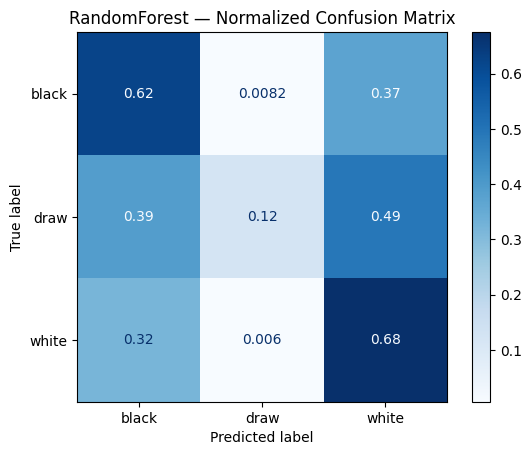

C:\Users\faith.DESKTOP-4NAFTJ5\AppData\Local\Temp\ipykernel_7692\730271977.py:78: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tbl = df_in.pivot_table(index=bucket_col, columns="winner", aggfunc="size", fill_value=0)


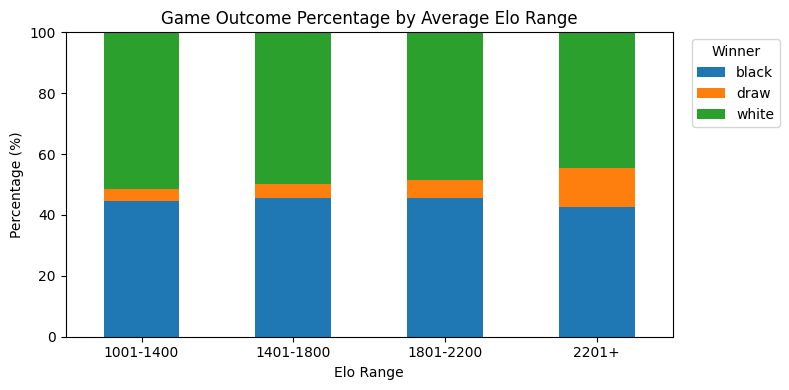

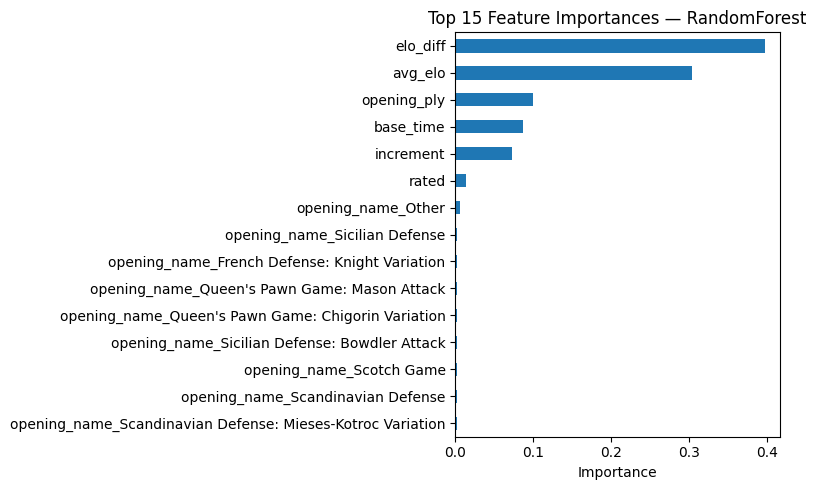

In [ ]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

RANDOM_STATE = 8

# read
df = pd.read_csv("games.csv")

# dropped columns that do not contribute to game result
df.drop(columns=['id','created_at','last_move_at','white_id','black_id','moves'],
        inplace=True, errors='ignore')

# keeping relevant columns
df.dropna(subset=['winner','white_rating','black_rating','opening_name','increment_code'], inplace=True)

# elo diff and avg elo
df['elo_diff'] = df['white_rating'] - df['black_rating']
df['avg_elo']  = (df['white_rating'] + df['black_rating']) / 2

# time control
bt_inc = df['increment_code'].str.split('+', expand=True)
df['base_time'] = bt_inc[0].astype(int)
df['increment'] = bt_inc[1].astype(int)
df.drop(columns=['increment_code','opening_eco'], inplace=True, errors='ignore')

df['rated'] = df['rated'].astype(int)

# drop post game leaks
for c in ['turns','victory_status']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# target
le = LabelEncoder()
df['winner_label'] = le.fit_transform(df['winner'])  

# one hot encoding top 10 openings
top_openings = df['opening_name'].value_counts().nlargest(10).index
df['opening_name'] = df['opening_name'].where(df['opening_name'].isin(top_openings), 'Other')
df = pd.get_dummies(df, columns=['opening_name'])

# features
FEATURES = ['rated','opening_ply','elo_diff','avg_elo','base_time','increment'] \
           + [c for c in df.columns if c.startswith('opening_name_')]
X = df[FEATURES]
y = df['winner_label']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# model
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)

# evaluation
y_pred_rf = rf_model.predict(X_test)
print(f"RF Accuracy : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"RF Macro-F1: {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print("\nClassification Report (RF):\n",
      classification_report(y_test, y_pred_rf, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, display_labels=le.classes_, normalize='true', cmap='Blues'
)
plt.title("RandomForest — Normalized Confusion Matrix")
plt.show()

# display
def stacked_percent_bar(df_in, bucket_col, title, order=None):
    tbl = df_in.pivot_table(index=bucket_col, columns="winner", aggfunc="size", fill_value=0)
    pct = (tbl.div(tbl.sum(axis=1), axis=0) * 100)
    if order is not None:
        pct = pct.reindex(order)
    ax = pct.plot(kind="bar", stacked=True, figsize=(8,4))
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel(bucket_col.replace("_"," ").title())
    ax.set_ylim(0, 100)
    ax.legend(title="Winner", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# avg elo bins
elo_bins   = [1000, 1400, 1800, 2200, 3000]
elo_labels = ['1001-1400', '1401-1800', '1801-2200', '2201+']
df['elo_range'] = pd.cut(df['avg_elo'], bins=elo_bins, labels=elo_labels, include_lowest=True, right=True)

stacked_percent_bar(
    df.dropna(subset=['elo_range']),
    'elo_range',
    title="Game Outcome Percentage by Average Elo Range",
    order=elo_labels
)

# feature importance
importances_rf = pd.Series(rf_model.feature_importances_, index=X.columns) \
                   .sort_values(ascending=False)

top_rf = importances_rf.head(15)
plt.figure(figsize=(8,5))
top_rf.iloc[::-1].plot(kind="barh")
plt.title("Top 15 Feature Importances — RandomForest")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



Best GBC params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

RF  -> Acc: 0.6246 | Macro-F1: 0.4885
GBC -> Acc: 0.6281 | Macro-F1: 0.4305


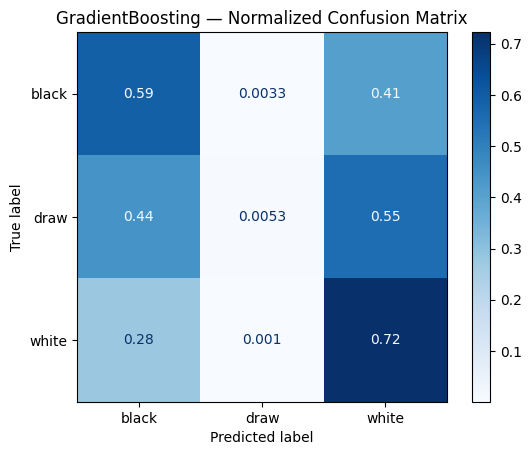


Chosen final model: RandomForest
Saved: chess_winner_model.pkl, column_order.txt, winner_classes.txt


C:\Users\faith.DESKTOP-4NAFTJ5\AppData\Local\Temp\ipykernel_7692\4004205697.py:54: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tbl = df_in.pivot_table(index=bucket_col, columns="winner", aggfunc="size", fill_value=0)


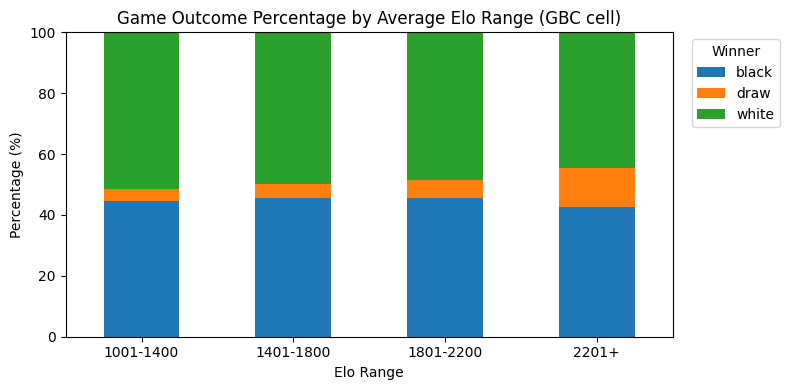

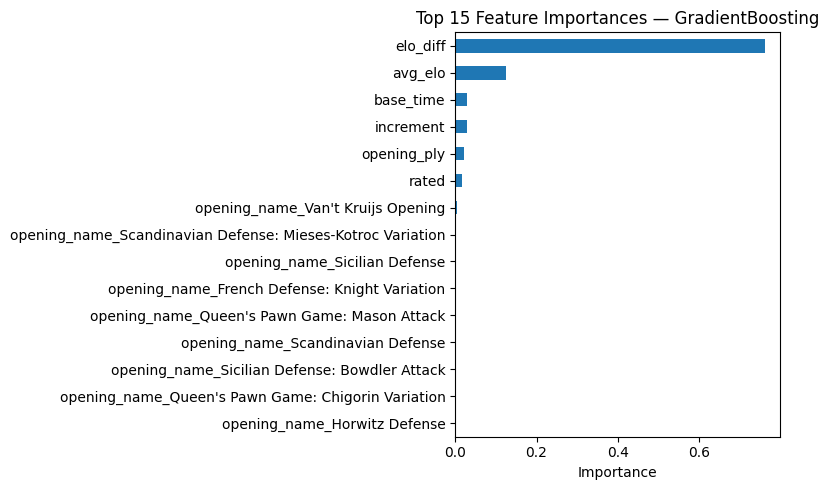

,white_rating,black_rating,opening_ply,base_time,increment
count,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000
mean,1596.631868,1588.831987,4.816981,13.824110,5.249626
std,291.253376,291.036126,2.797152,17.160179,14.289591
min,784.000000,789.000000,1.000000,0.000000,0.000000
25%,1398.000000,1391.000000,3.000000,10.000000,0.000000
50%,1567.000000,1562.000000,4.000000,10.000000,0.000000
75%,1793.000000,1784.000000,6.000000,15.000000,7.000000
max,2700.000000,2723.000000,28.000000,180.000000,180.000000


In [ ]:
# imports
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pandas as pd

RANDOM_STATE = 8

#training
gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)
param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [2, 3],
}
gbc_search = GridSearchCV(gbc, param_grid, cv=5, scoring="f1_macro", n_jobs=-1)
gbc_search.fit(X_train, y_train)
gbc_best = gbc_search.best_estimator_
print("Best GBC params:", gbc_search.best_params_)

# compare models with f1 to dictate model performance
y_pred_gbc = gbc_best.predict(X_test)
acc_rf  = accuracy_score(y_test, y_pred_rf)
f1_rf   = f1_score(y_test, y_pred_rf, average='macro')
acc_gbc = accuracy_score(y_test, y_pred_gbc)
f1_gbc  = f1_score(y_test, y_pred_gbc, average='macro')

print(f"\nRF  -> Acc: {acc_rf:.4f} | Macro-F1: {f1_rf:.4f}")
print(f"GBC -> Acc: {acc_gbc:.4f} | Macro-F1: {f1_gbc:.4f}")

# confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_gbc, display_labels=le.classes_, normalize='true', cmap='Blues'
)
plt.title("GradientBoosting — Normalized Confusion Matrix")
plt.show()

# choose higher score mdoel
final_model, final_name = (gbc_best, "GradientBoosting") if f1_gbc >= f1_rf else (rf_model, "RandomForest")
print(f"\nChosen final model: {final_name}")

# save pkl
joblib.dump(final_model, "chess_winner_model.pkl")   
with open("column_order.txt", "w") as f:
    for col in X.columns:
        f.write(col + "\n")
np.savetxt("winner_classes.txt", le.classes_, fmt="%s")
print("Saved: chess_winner_model.pkl, column_order.txt, winner_classes.txt")

# display bars
def _stacked_percent_bar(df_in, bucket_col, title, order=None):
    tbl = df_in.pivot_table(index=bucket_col, columns="winner", aggfunc="size", fill_value=0)
    pct = (tbl.div(tbl.sum(axis=1), axis=0) * 100)
    if order is not None:
        pct = pct.reindex(order)
    ax = pct.plot(kind="bar", stacked=True, figsize=(8,4))
    ax.set_title(title)
    ax.set_ylabel("Percentage (%)")
    ax.set_xlabel(bucket_col.replace("_"," ").title())
    ax.set_ylim(0, 100)
    ax.legend(title="Winner", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# elo bucket display
if "avg_elo" not in df.columns:
    df["avg_elo"] = (df["white_rating"] + df["black_rating"]) / 2

elo_bins   = [1000, 1400, 1800, 2200, 3000]
elo_labels = ['1001-1400', '1401-1800', '1801-2200', '2201+']
df["elo_range"] = pd.cut(df["avg_elo"], bins=elo_bins, labels=elo_labels, include_lowest=True, right=True)

_stacked_percent_bar(
    df.dropna(subset=["elo_range"]),
    "elo_range",
    title="Game Outcome Percentage by Average Elo Range (GBC cell)",
    order=elo_labels
)

# feature importance
importances_gbc = pd.Series(gbc_best.feature_importances_, index=X.columns) \
                    .sort_values(ascending=False)

top_gbc = importances_gbc.head(15)
plt.figure(figsize=(8,5))
top_gbc.iloc[::-1].plot(kind="barh")
plt.title("Top 15 Feature Importances — GradientBoosting")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


df[['white_rating','black_rating','opening_ply','base_time','increment']].describe()
